In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 3
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 500
tries = 10

x_train, y_train, x_test, y_test, rotation = pickle.load(open('data.pickle', 'rb'))

x_test = x_test[:n_test]
y_test = y_test[:n_test]

'''
rotation = special_ortho_group.rvs(dim_in)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(1000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)
'''

sample_range = [100, 200, 400, 800]

M = 50                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

In [2]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

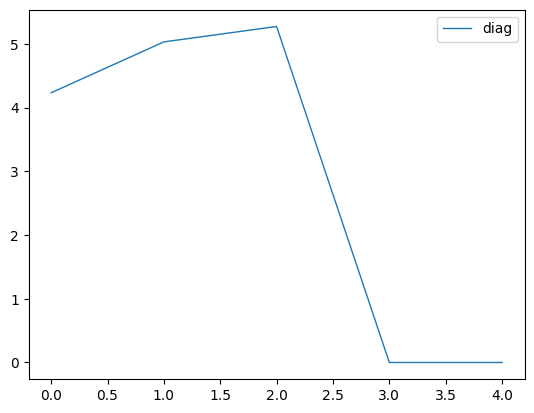

In [3]:
eigenvalues, eigenvectors = linalg.eig(true_H)
draw(dim_in, eigenvalues)

In [4]:
def plot_trend(stats, x_axis, y_axis, title, xlabel = None, ylabel = None):
    df = pd.DataFrame(stats)

    # Prepare the data for plotting
    plot_data = [df[y_axis][i] for i in range(len(df))]

    # Create the boxplot
    plt.boxplot(plot_data, labels=[str(x[x_axis]) for x in stats])

    # Add titles and labels
    plt.title(title)
    if xlabel is None:
        xlabel = x_axis
    if ylabel is None:
        ylabel = y_axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.show()

 25%|██▌       | 1/4 [00:07<00:21,  7.33s/it]

min mse: 0.5387509
time: 4.633671080917486


 50%|█████     | 2/4 [00:22<00:23, 11.98s/it]

min mse: 0.39100856
time: 4.996486062174961


 75%|███████▌  | 3/4 [01:04<00:25, 25.85s/it]

min mse: 0.35454443
time: 4.981427603873476


100%|██████████| 4/4 [04:06<00:00, 61.51s/it]

min mse: 0.28084862
time: 4.884408665748416


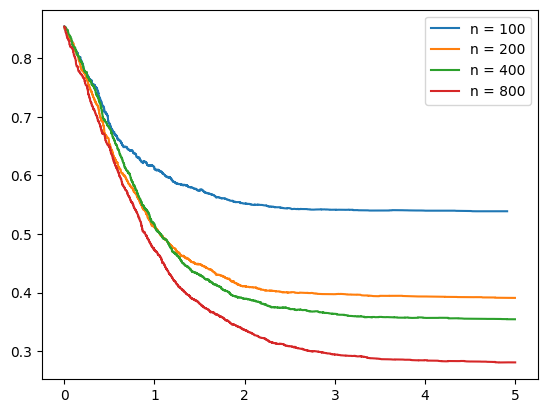

In [5]:
lifetime_max = 5
for n_sim in tqdm(sample_range):
    results = evaluate_all_lifetimes(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)
    print("min mse: " + str(min(results['mse'])))
    print("time: " + str(results['times'][np.where(results['mse'] == min(results['mse']))[0][0]]))
    plt.plot(results['times'], results['mse'], label = 'n = ' + str(n_sim))
    plt.legend()


# Save training history

In [6]:
lifetime = 4
tries = 3
stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all = \
            one_run(x_train[:n_sim, ], y_train[:n_sim], x_test, M, lifetime, delta)
        dist['history'].append((y_hat_test, history, X_bd_all))
    stats.append(dist)

100%|██████████| 3/3 [26:45<00:00, 535.04s/it]


# With increasing lifetime

In [8]:
tries = 3
def get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H):
    H_est = []
    for i in range(len(sample_range)):
        n_sim = sample_range[i]
        dist = {'n': n_sim, 'mse': [], 'H': []}
        for trial in tqdm(range(tries)):
            y_hat_test, history, X_bd_all = \
                stats[i]['history'][trial]
            dist['mse'].append(mean_squared_error(y_test, y_hat_test))
            H_0 = estimate_H(x_train[:n_sim, ], y_train[:n_sim], X_bd_all, M, x_test, history, delta, y_hat_test)
            dist['H'].append(H_0)
        H_est.append(dist)
        
    return H_est

raw_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_ind)

100%|██████████| 3/3 [25:07<00:00, 502.54s/it]


In [9]:
def operator_norm(H, truth):
    norm_truth = norm(truth, ord = 2)
    return norm(truth - H, ord = 2)/norm_truth

def get_eig(A):
    eigenValues, eigenVectors = linalg.eig(A)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    print(eigenValues)
    eigenVectors = eigenVectors[:,idx]
    return eigenVectors

def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')
    
    eigenvectors = get_eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :active])
    
    eigenvectors = get_eig(truth)
    Q_t, _ = linalg.qr(eigenvectors[:, :active])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    S = np.minimum(S, 1)
    return np.max(np.arccos(S))

['0.9974', '0.9979', '0.9986']
['0.9989', '0.9992', '0.9988']
['0.9988', '0.9987', '0.9985']
['0.9986', '0.9985', '0.9981']


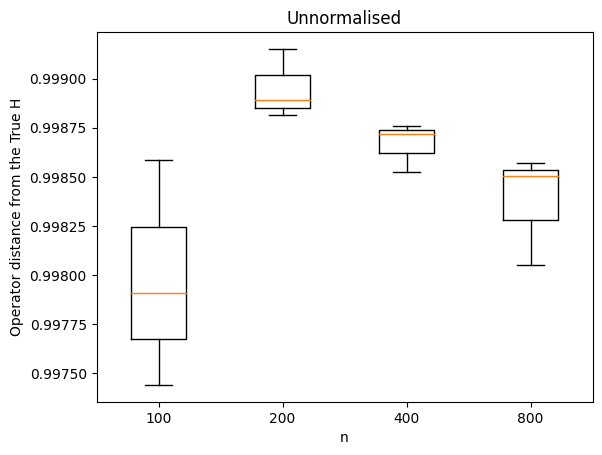

['1.3964', '1.2958', '0.9827']
['0.7498', '0.9571', '0.8026']
['0.9067', '0.9732', '0.9268']
['0.6283', '0.6481', '0.6675']


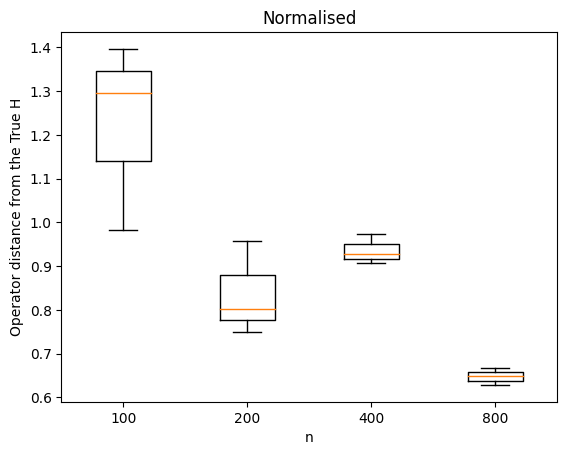

In [10]:
def plot_dist(H_estimates, title, true_H, norm_H, norm_func):
    plot_data = []
    for i in range(len(sample_range)):
        dist = H_estimates[i]
        n_sim = sample_range[i]
        alter_dist = {'n': n_sim, 'dist':[]}
        for trial in range(tries):
            H_0 = dist['H'][trial]
            alter_dist['dist'].append(norm_func(H_0, true_H))
        print([f'{x:.4f}' for x in alter_dist['dist']])
        plot_data.append(alter_dist)
    try:
        plot_trend(plot_data, 'n', 'dist', title, ylabel='Operator distance from the True H')
    except:
        pass


def plot_H_estimates(raw_H_estimates, true_H, norm_func):

    norm_H = norm(true_H, ord = 2)
    plot_dist(raw_H_estimates, 'Unnormalised', true_H, norm_H, norm_func)
    
    H_estimates = deepcopy(raw_H_estimates)
    normed_H_estimates = []
    for i in range(len(sample_range)):
        dist = H_estimates[i]
        for trial in range(tries):
            H_0 = dist['H'][trial]
            H_0 = H_0 / two_one_norm(H_0)
            dist['H'][trial] = H_0
        normed_H_estimates.append(dist)

    true_H_normed = true_H/two_one_norm(true_H)
    norm_H_normed = norm(true_H_normed, ord = 2)

    plot_dist(H_estimates, 'Normalised', true_H_normed, norm_H_normed, norm_func)


plot_H_estimates(raw_H_estimates, true_H, operator_norm)

[0.0282 0.0132 0.0044 0.0033 0.0009]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0204 0.0111 0.0064 0.0037 0.0009]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0129 0.009  0.0062 0.0036 0.002 ]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
['1.4375', '1.4988', '0.8311']
[0.0168 0.0134 0.0036 0.0027 0.0012]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0179 0.0089 0.004  0.0035 0.0015]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0195 0.0126 0.0049 0.0037 0.0009]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
['0.8570', '1.5236', '0.9412']
[0.0168 0.0106 0.0069 0.0061 0.0011]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0175 0.0089 0.0065 0.0049 0.0016]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.015  0.0092 0.008  0.0061 0.0014]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
['0.9364', '0.7395', '0.8919']
[0.0207 0.013  0

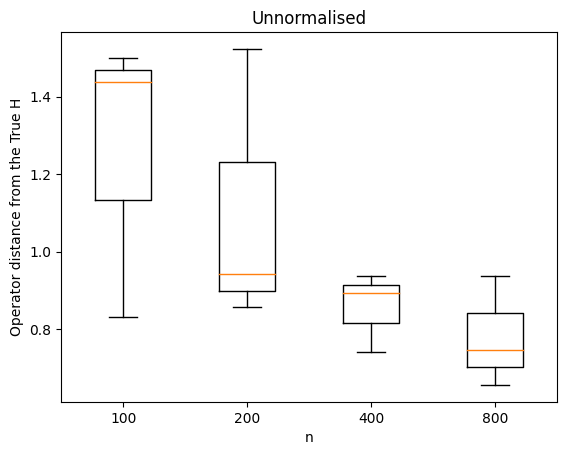

[2.6674 1.2446 0.4156 0.316  0.0869]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[2.2823 1.2403 0.7165 0.4178 0.1031]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.8499 1.2883 0.8854 0.5188 0.2861]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
['1.4375', '1.4988', '0.8311']
[2.1806 1.7482 0.4675 0.3472 0.1547]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[2.4504 1.2088 0.5442 0.4768 0.2014]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[2.3392 1.5087 0.5856 0.4464 0.1034]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
['0.8570'

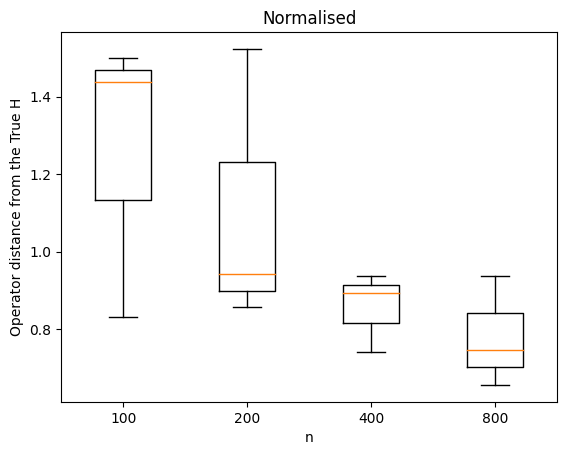

In [11]:
np.set_printoptions(precision=4)
plot_H_estimates(raw_H_estimates, true_H, get_angle_distance)

# Eliza's method for estimating gradients

In [12]:
def estimate_H_ind_(x_train, y_train, X_bd_all, M, X_test, history, delta, y_hat_test):
    dim_in = X_test.shape[1]
    N_test = X_test.shape[0]
    importance = []
    for dim in range(dim_in):
        try:
            x_eval = None
            y_eval = []
            x_diff = []
            subset_all = []
            for tree in range(M):
                temp = X_bd_all[tree,dim] - X_test
                subset = temp[:,dim] != 0
                subset_all = subset_all + list(subset)
                
                if sum(subset) > 0:
                    if x_eval is None:
                        x_eval = X_bd_all[tree,dim][subset]
                    else:
                        x_eval = np.vstack((x_eval, X_bd_all[tree,dim][subset]))
                    y_eval = y_eval + y_hat_test[subset].tolist()
                    x_diff = x_diff + list(temp[:,dim][subset])
            
            _, y_hat_eval = evaluate(x_train, y_train, x_eval, M, history, delta)
            y_eval = np.array(y_eval)
            x_diff = np.abs(x_diff)
            y_diff = populate_importance(subset_all, y_eval - y_hat_eval)
            x_diff = populate_importance(subset_all, x_diff)
            y_diff = np.reshape(y_diff, (N_test, M))
            x_diff = np.reshape(x_diff, (N_test, M))
            y_diff = np.mean(y_diff, axis = 1)
            x_diff = np.mean(x_diff, axis = 1)
            y_diff[x_diff == 0] = 0
            x_diff[x_diff == 0] = 1
            importance_temp = y_diff/x_diff
        except:
            importance_temp = np.zeros(N_test)
        importance.append(importance_temp)
    importance = np.vstack(importance)

    H = np.matmul(importance, np.transpose(importance))/N_test
    return H

alter_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_ind_)

100%|██████████| 3/3 [38:06<00:00, 762.27s/it] 


['0.9947', '0.9958', '0.9947']
['0.9929', '0.9935', '0.9944']
['0.9944', '0.9924', '0.9935']
['0.9926', '0.9911', '0.9915']


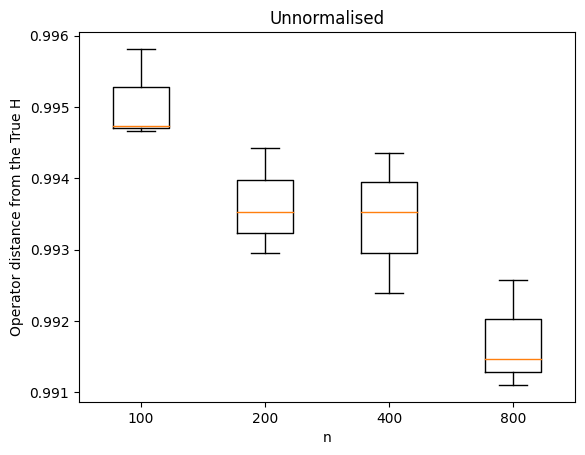

['1.2606', '0.6637', '0.7494']
['0.6575', '0.6876', '0.7723']
['0.6666', '0.5394', '0.6200']
['0.6628', '0.5949', '0.6855']


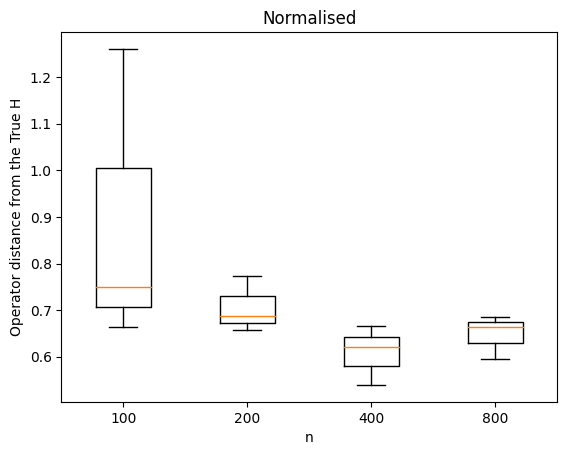

In [13]:
plot_H_estimates(alter_H_estimates, true_H, operator_norm)

[0.0362 0.0131 0.0117 0.004  0.    ]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.034  0.0245 0.0131 0.0099 0.0036]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0352 0.025  0.018  0.0106 0.0046]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
['1.3180', '0.5672', '0.6618']
[0.0512 0.0302 0.0229 0.0157 0.0033]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.048  0.0328 0.0221 0.0165 0.0036]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0436 0.0288 0.0176 0.0151 0.0028]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
['0.3265', '0.5792', '0.5227']
[0.0477 0.0265 0.0176 0.0129 0.0033]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0459 0.0236 0.0203 0.0131 0.0039]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0436 0.025  0.0181 0.0137 0.0035]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
['0.4842', '0.5403', '0.4323']
[0.0586 0.034  0

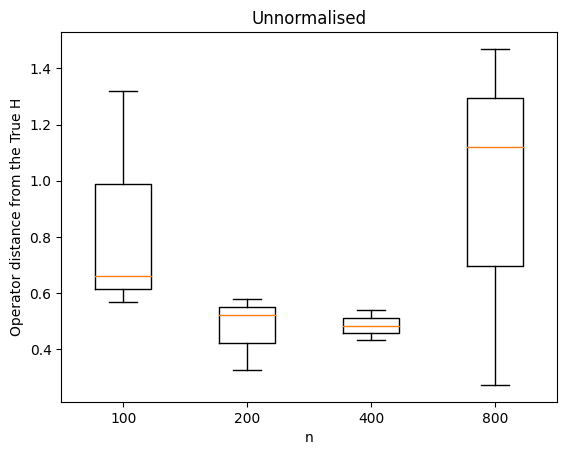

[2.6949 0.972  0.8701 0.2991 0.    ]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.921  1.385  0.7374 0.5571 0.2033]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.8291 1.2979 0.9361 0.5497 0.2369]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
['1.3180', '0.5672', '0.6618']
[1.9702 1.1635 0.8828 0.606  0.1285]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.8812 1.2835 0.8659 0.6464 0.1406]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.9354 1.2793 0.7834 0.6725 0.1258]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
['0.3265'

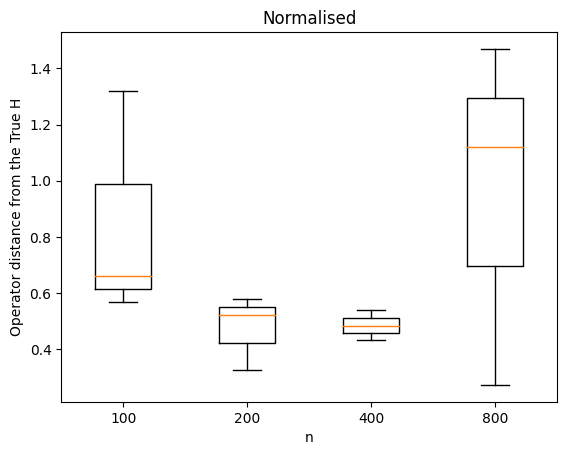

In [14]:
plot_H_estimates(alter_H_estimates, true_H, get_angle_distance)